### Tidal elevations to NAVD88 conversion: https://geodesy.noaa.gov/Tidal_Elevation/index.xhtml;jsessionid=69C1903BDFAE54609A9080BC4D41D1D9

# Using the NOAA tidal gage at Mayport for the MHW: https://tidesandcurrents.noaa.gov/datums.html?datum=NAVD88&units=0&epoch=0&id=8720218&name=Mayport+%28Bar+Pilots+Dock%29&state=FL
MHW NAVD88 = 1.70 ft = 0.518 m


In [48]:
import folium
import json
import os
# Show ADCIRC points on map using folium and a geojson
geojson_fn = "CHS ADCIRC Test Points.geojson" 
m = folium.Map(location=[30.3322, -81.6557], tiles="CartoDB Positron", zoom_start=10)

tooltip = folium.GeoJsonTooltip(
    fields=["Point"],
    aliases=["ADCIRC Point"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

folium.GeoJson(
    geojson_fn,
    tooltip=tooltip).add_to(m)

# Add the NOAA tide gauge location to folium map
folium.Marker([30.398, -81.428], 
              popup='<i>NOAA Tide Gauge 8720218</i>', 
              tooltip='Mayport (Bar Pilots Dock), FL', 
              icon=folium.Icon(color='red', icon_color='white', icon='ship', angle=0, prefix='fa')).add_to(m)

m

In [49]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import glob

# Get the list of ADCIRC points from the geojson
with open(geojson_fn) as f:
    data = json.load(f)
    points = [feature["properties"]["Point"] for feature in data["features"]]

In [50]:
storms = []
# look just at point 17808
point = 17808
h5_fn = f"CHS-SA_TS_SimB_ADCIRC01_Peaks/CHS-SA_TS_SimB_Post0_SP{point}_ADCIRC01_Peaks.h5"
with h5py.File(h5_fn, "r") as f:
        peak_wse = f["Water Elevation"][:]
        storms.extend([storm.decode('utf-8') for storm in f['Storm Name'][:]])

print(f"Number of storms: {len(storms)}")

Number of storms: 1059


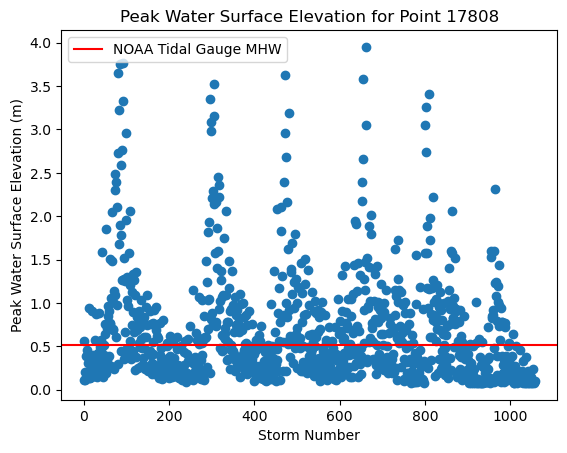

In [51]:
# Make a scatter Plot of the peak water surface elevations for each storm for the ADCIRC location 17808. x-axis is storm number, y-axis is peak water surface elevation.
plt.scatter(range(len(peak_wse)), peak_wse)
plt.xlabel("Storm Number")
plt.ylabel("Peak Water Surface Elevation (m)")
plt.title(f"Peak Water Surface Elevation for Point {point}")
# Add a marker line for the mean peak water surface elevation of the Noaa tide gauge = 0.518 m. With a label of "NOAA Tidal Gauge MHW".
plt.axhline(y=0.518, color='r', linestyle='-', label="NOAA Tidal Gauge MHW")
# Show the legend
plt.legend()

plt.show()


In [52]:
# Get storm list that is above the NOAA MHW value of 0.518 m in to a pandas dataframe.
df = pd.DataFrame({'Storm': storms, 'Peak WSE (m)': peak_wse})
# Limit the dataframe to just the storms that are above the NOAA MHW value of 0.518 m.
df = df[df['Peak WSE (m)'] > 0.518]
#export to csv
df.to_csv('storms_above_MHW_17808.csv', index=False)
df

,Storm,Peak WSE (m)
1,Synthetic_0066,0.561101
12,Synthetic_0077,0.941145
20,Synthetic_0085,0.903874
27,Synthetic_0092,0.576928
29,Synthetic_0094,0.871933
...,...,...
982,Synthetic_1624,0.785078
988,Synthetic_1630,0.719467
989,Synthetic_1631,0.764964
997,Synthetic_1639,0.534902


### Additional Points Filtered to the 1yr return period at 17808 = 1.6m (NAVD88)
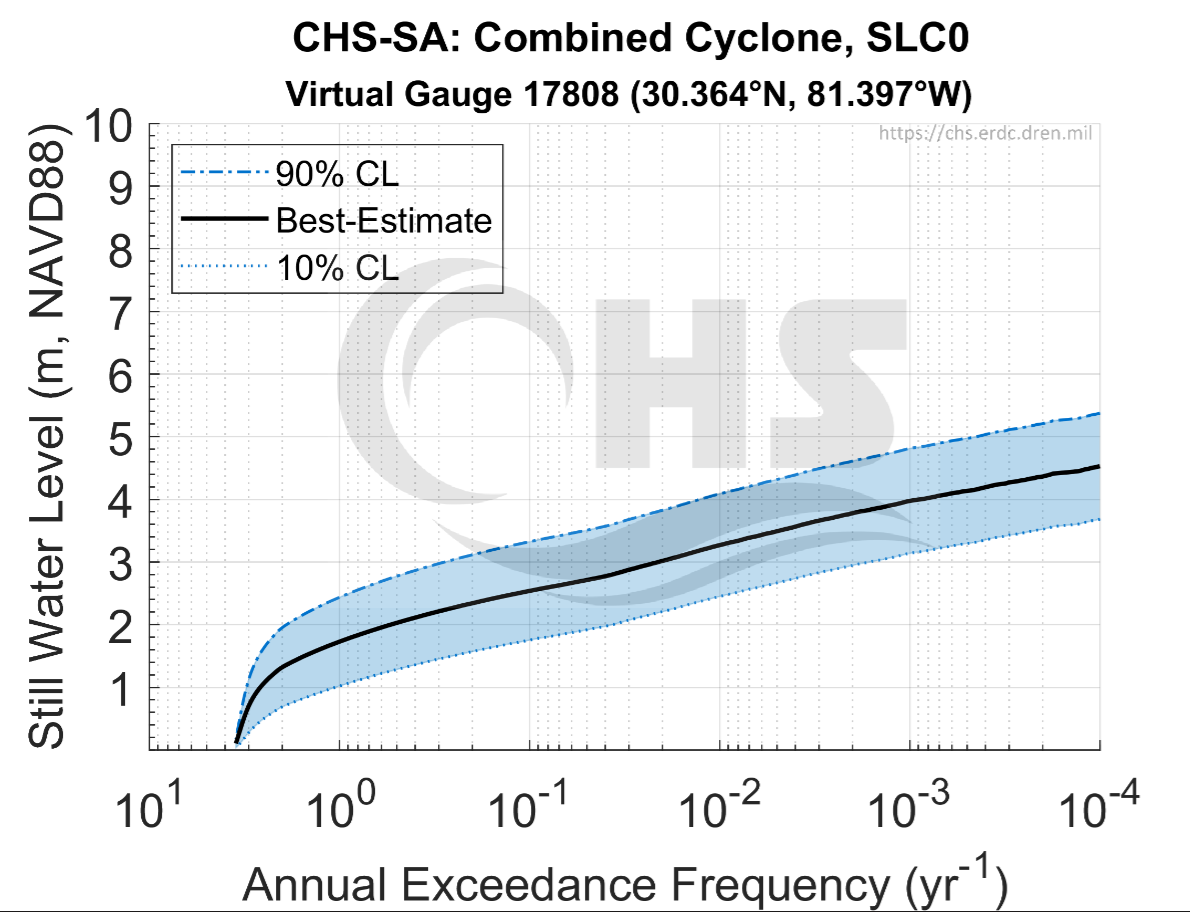


In [53]:
# Points of interest: 17804, 17808, 18090
# Get the list of ADCIRC points from the geojson
# points = [17804, 17808, 18090]
threshold = 1.6
# For each point, get the peak water surface elevation for each storm and add it to a pandas dataframe.
df_all = pd.DataFrame()
for point in points:
    h5_fn = f"CHS-SA_TS_SimB_ADCIRC01_Peaks/CHS-SA_TS_SimB_Post0_SP{point}_ADCIRC01_Peaks.h5"
    with h5py.File(h5_fn, "r") as f:
        peak_wse = f["Water Elevation"][:]
        storms = [storm.decode('utf-8') for storm in f['Storm Name'][:]]
    df = pd.DataFrame({'Point': point, 'Storm': storms, 'Peak WSE (m)': peak_wse})
    # Append the dataframe to the main dataframe
    df_all = pd.concat([df_all, df], ignore_index=True)

df_all


,Point,Storm,Peak WSE (m)
0,17393,Synthetic_0065,0.107892
1,17393,Synthetic_0066,0.531390
2,17393,Synthetic_0067,0.120196
3,17393,Synthetic_0068,0.200591
4,17393,Synthetic_0069,0.337475
...,...,...,...
19057,18107,Synthetic_1696,0.103892
19058,18107,Synthetic_1697,0.100380
19059,18107,Synthetic_1698,0.080240
19060,18107,Synthetic_1699,0.089143


In [54]:
# Remove missing Peak WSE values
df_all = df_all[df_all['Peak WSE (m)'] > 0]
# Get list of points with data
points = df_all['Point'].unique()

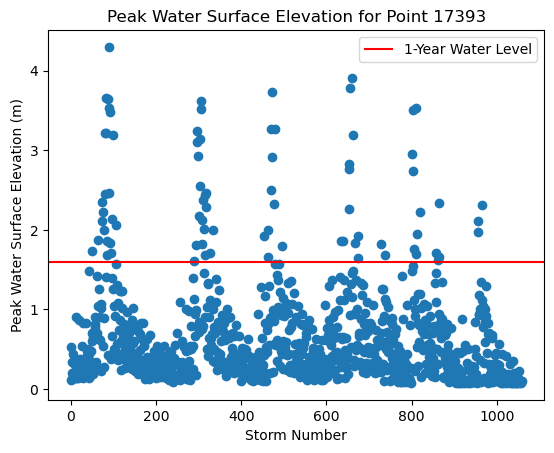

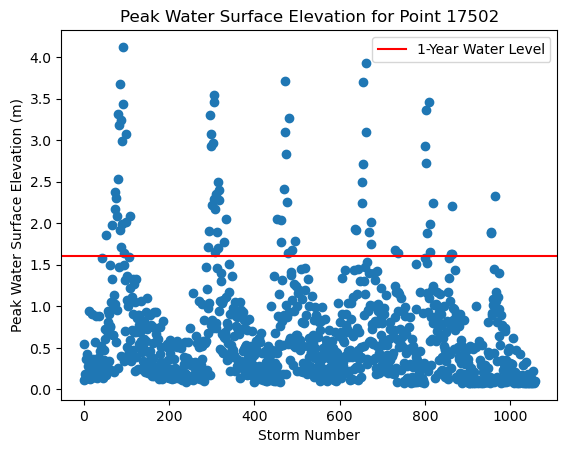

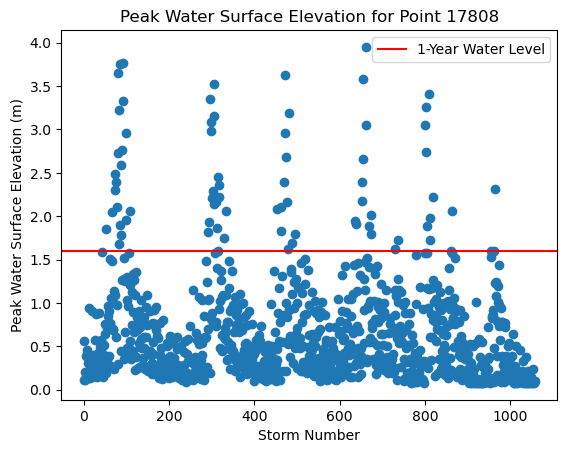

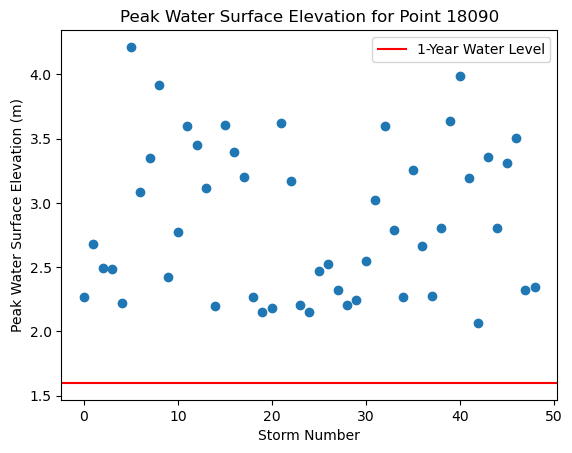

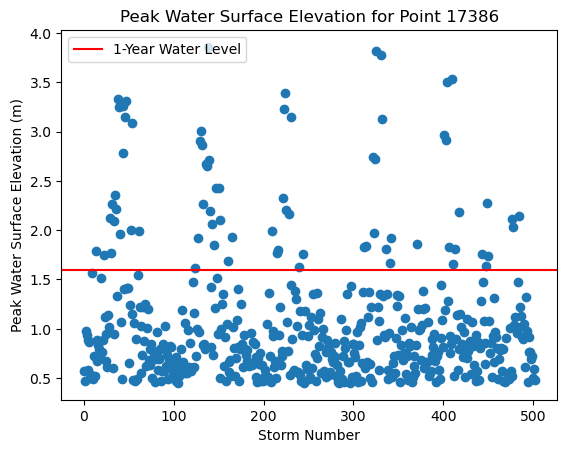

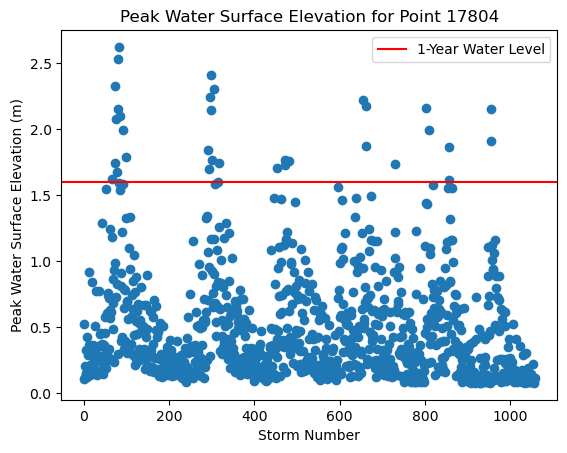

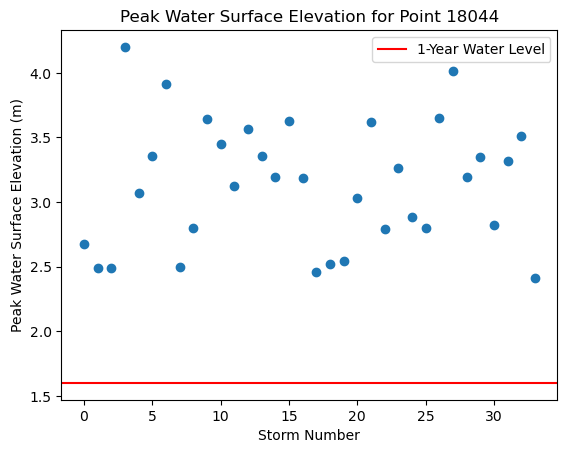

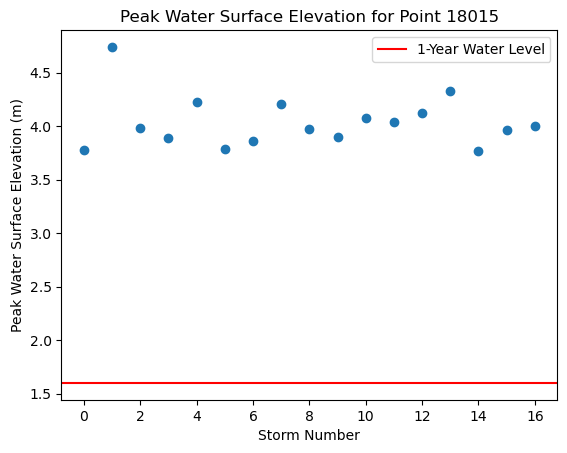

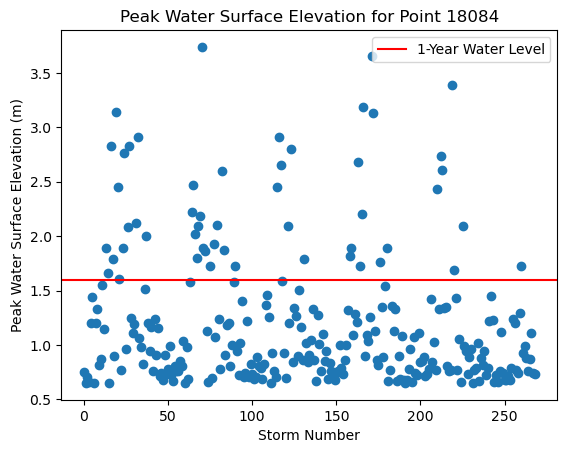

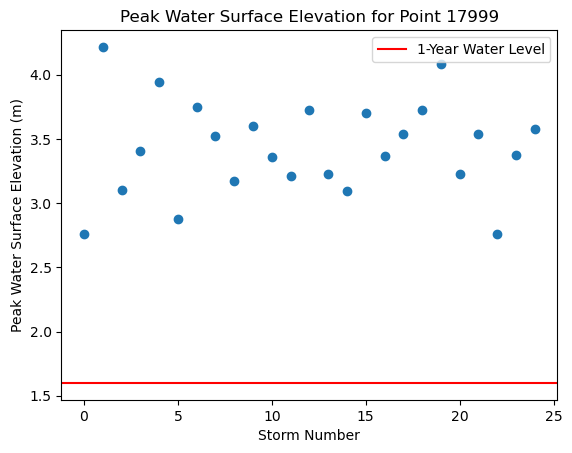

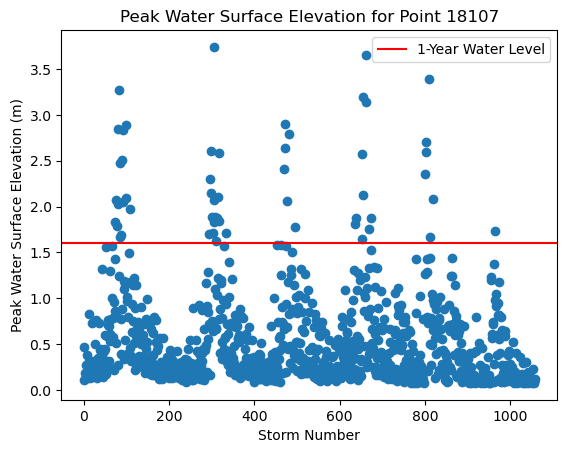

In [55]:
# Plot each point on a separate plot. x-axis is storm number, y-axis is peak water surface elevation. Add a marker line for the threshold. With a label of "1-Year Water Level".
for point in points:
    df = df_all[df_all['Point'] == point]
    plt.scatter(range(len(df['Peak WSE (m)'])), df['Peak WSE (m)'])
    plt.xlabel("Storm Number")
    plt.ylabel("Peak Water Surface Elevation (m)")
    plt.title(f"Peak Water Surface Elevation for Point {point}")
    # Add a marker line for the threshold. With a label of "1-Year Water Level".
    plt.axhline(y=threshold, color='r', linestyle='-', label="1-Year Water Level")
    # Show the legend
    plt.legend()
    # Save the plot
    plt.savefig(f"output/Peak_WSE_Point_{point}.png")
    plt.show()
    

In [56]:
# Remove events that are below the threshold.
df_all = df_all[df_all['Peak WSE (m)'] > threshold]
# df_all to csv
df_all.to_csv('Multiple Points Above 1Year Elevation.csv', index=False)

In [57]:
# Count the rows for each point.
df_all.groupby('Point').count()

,Storm,Peak WSE (m)
Point,,
17386,74,74
17393,80,80
17502,80,80
17804,34,34
17808,74,74
17999,25,25
18015,17,17
18044,34,34
18084,52,52


In [58]:
# Create a folium map with the ADCIRC points in df_all, and the NOAA tide gauge location.
m = folium.Map(location=[30.3322, -81.6557], tiles="CartoDB Positron", zoom_start=10)
# get list of points from df_all
points = df_all['Point'].unique()
# filter geojson points to just the points in df_all
with open(geojson_fn) as f:
    data = json.load(f)
    features = [feature for feature in data["features"] if feature["properties"]["Point"] in points]
    data["features"] = features
    # Add the ADCIRC points to the folium map
    folium.GeoJson(data, tooltip=tooltip).add_to(m)
# Add the NOAA tide gauge location to folium map
folium.Marker([30.398, -81.428], 
              popup='<i>NOAA Tide Gauge 8720218</i>', 
              tooltip='Mayport (Bar Pilots Dock), FL', 
              icon=folium.Icon(color='red', icon_color='white', icon='ship', angle=0, prefix='fa')).add_to(m)
m